# <center> Speech Emotion Recognition <center>


#### Datasets used in this project

- Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)


# Importing Libraries


In [1]:
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation

- As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
- We will use this dataframe to extract features for our model training.


In [2]:
# Paths for data.
Ravdess = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
# Crema = "cremad/AudioWAV/"
# Tess = "toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
# Savee = "surrey-audiovisual-expressed-emotion-savee/ALL/"

## <center> 1. Ravdess Dataframe <center>

Here is the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)


In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split(".")[0]
        part = part.split("-")
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + "/" + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=["Path"])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace(
    {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fear",
        7: "disgust",
        8: "surprise",
    },
    inplace=True,
)
Ravdess_df.head()

Emotions                                               Path
0  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
1  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
2  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
3  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
4     calm  ravdess-emotional-speech-audio/audio_speech_ac...

## <center>2. Crema DataFrame</center>


In [4]:
# crema_directory_list = os.listdir(Crema)

# file_emotion = []
# file_path = []

# for file in crema_directory_list:
#     # storing file paths
#     file_path.append(Crema + file)
#     # storing file emotions
#     part = file.split("_")
#     if part[2] == "SAD":
#         file_emotion.append("sad")
#     elif part[2] == "ANG":
#         file_emotion.append("angry")
#     elif part[2] == "DIS":
#         file_emotion.append("disgust")
#     elif part[2] == "FEA":
#         file_emotion.append("fear")
#     elif part[2] == "HAP":
#         file_emotion.append("happy")
#     elif part[2] == "NEU":
#         file_emotion.append("neutral")
#     else:
#         file_emotion.append("Unknown")

# # dataframe for emotion of files
# emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])

# # dataframe for path of files.
# path_df = pd.DataFrame(file_path, columns=["Path"])
# Crema_df = pd.concat([emotion_df, path_df], axis=1)
# Crema_df.head(10)

## <center> 3. TESS dataset <center>


In [5]:
# tess_directory_list = os.listdir(Tess)

# file_emotion = []
# file_path = []

# for dir in tess_directory_list:
#     directories = os.listdir(Tess + dir)
#     for file in directories:
#         part = file.split(".")[0]
#         part = part.split("_")[2]
#         if part == "ps":
#             file_emotion.append("surprise")
#         else:
#             file_emotion.append(part)
#         file_path.append(Tess + dir + "/" + file)

# # dataframe for emotion of files
# emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])

# # dataframe for path of files.
# path_df = pd.DataFrame(file_path, columns=["Path"])
# Tess_df = pd.concat([emotion_df, path_df], axis=1)
# Tess_df.head()

## <center> 4. SEVEE dataset <center>

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

- 'a' = 'anger'
- 'd' = 'disgust'
- 'f' = 'fear'
- 'h' = 'happiness'
- 'n' = 'neutral'
- 'sa' = 'sadness'
- 'su' = 'surprise'


In [6]:
# savee_directory_list = os.listdir(Savee)

# file_emotion = []
# file_path = []

# for file in savee_directory_list:
#     file_path.append(Savee + file)
#     part = file.split("_")[1]
#     ele = part[:-6]
#     if ele == "a":
#         file_emotion.append("angry")
#     elif ele == "d":
#         file_emotion.append("disgust")
#     elif ele == "f":
#         file_emotion.append("fear")
#     elif ele == "h":
#         file_emotion.append("happy")
#     elif ele == "n":
#         file_emotion.append("neutral")
#     elif ele == "sa":
#         file_emotion.append("sad")
#     else:
#         file_emotion.append("surprise")

# # dataframe for emotion of files
# emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])

# # dataframe for path of files.
# path_df = pd.DataFrame(file_path, columns=["Path"])
# Savee_df = pd.concat([emotion_df, path_df], axis=1)
# Savee_df.head(10)

## Create Data_path Dataframe


In [7]:
# creating Dataframe using all the 4 dataframes we created so far. Ravdess_df Savee_df Crema_df Tess_df
data_path = Ravdess_df
# axis=0" means combining dataframes vertically, while "axis=1" means combining them horizontally
data_path.to_csv("data_path.csv", index=False)
# Output result not include index column
data_path.head(10)

Emotions                                               Path
0  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
1  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
2  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
3  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
4     calm  ravdess-emotional-speech-audio/audio_speech_ac...
5     calm  ravdess-emotional-speech-audio/audio_speech_ac...
6     calm  ravdess-emotional-speech-audio/audio_speech_ac...
7     calm  ravdess-emotional-speech-audio/audio_speech_ac...
8     calm  ravdess-emotional-speech-audio/audio_speech_ac...
9     calm  ravdess-emotional-speech-audio/audio_speech_ac...

## Data Visualisation and Exploration


First let's plot the count of each emotions in our dataset.


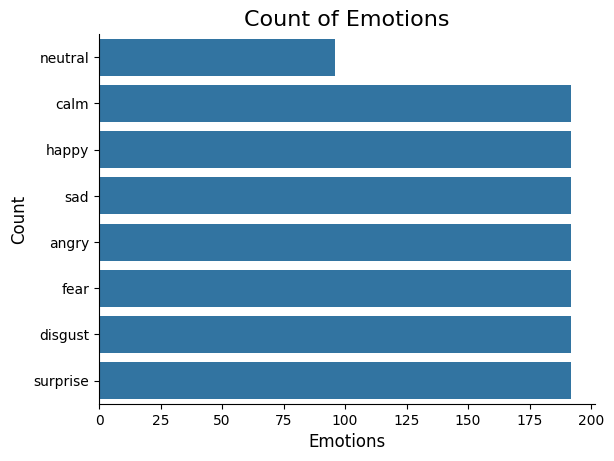

In [8]:
plt.title("Count of Emotions", size=16)
sns.countplot(data_path.Emotions)
plt.ylabel("Count", size=12)
plt.xlabel("Emotions", size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

- Waveplots - Waveplots let us know the loudness of the audio at a given time.
- Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.


In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title("Waveplot for audio with {} emotion".format(e), size=15)
    plt.plot(data)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title("Spectrogram for audio with {} emotion".format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="hz")
    # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

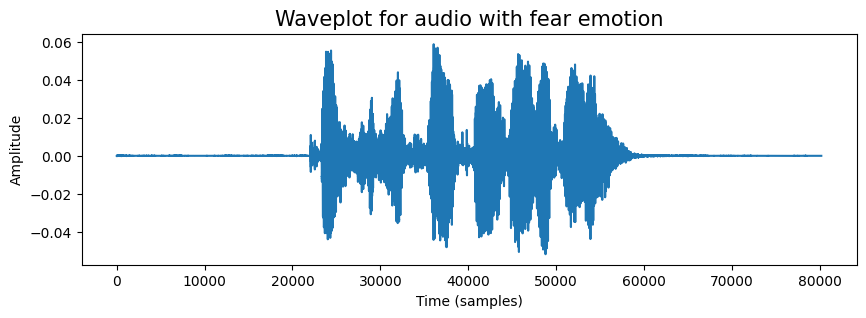

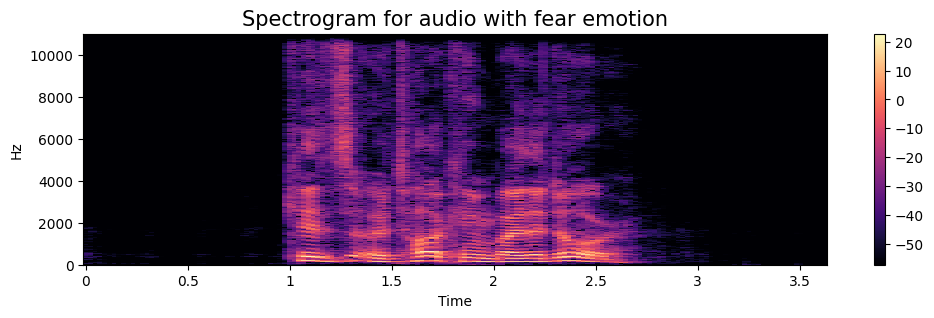

In [10]:
emotion = "fear"
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

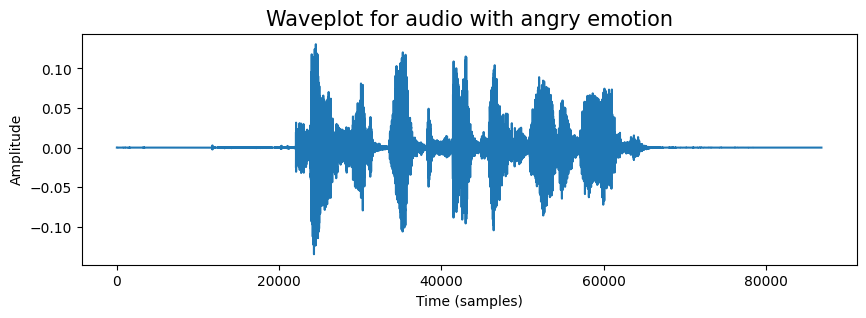

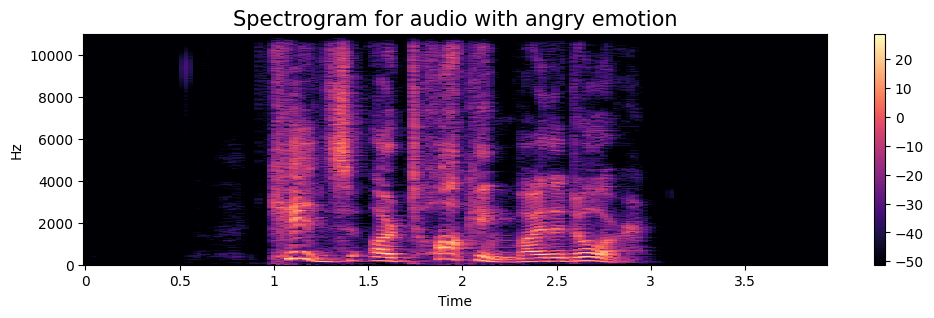

In [11]:
emotion = "angry"
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

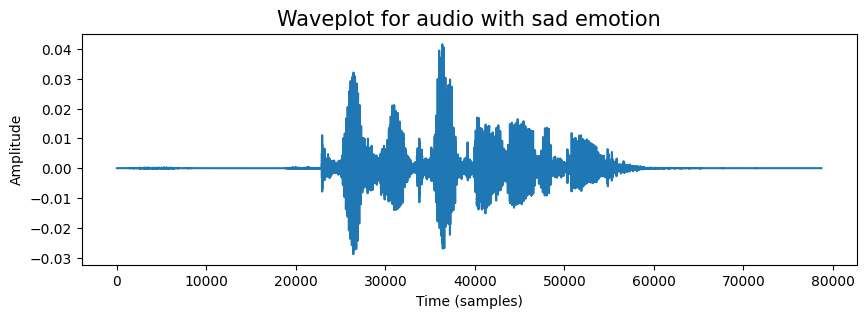

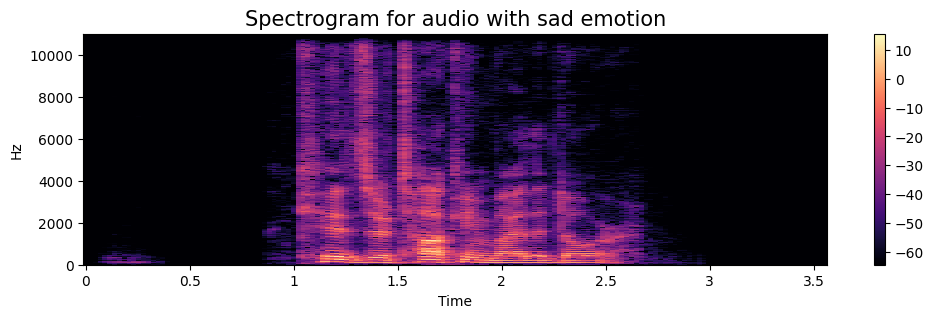

In [12]:
emotion = "sad"
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

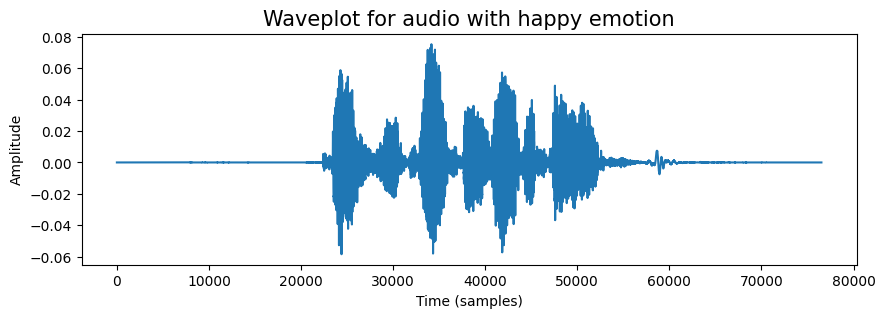

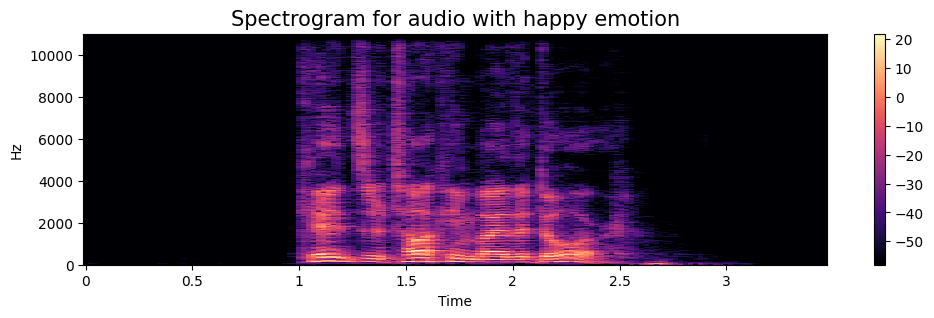

In [13]:
emotion = "happy"
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.


In [58]:

import numpy as np

def complex_noise_generation(data, noise_level=0.035, env_noise_level=0.02):
    """
    Generate complex noise by combining white noise and environmental noise.

    Args:
        data (numpy.ndarray): Audio data.
        noise_level (float): Level of white noise to be added (default is 0.035).
        env_noise_level (float): Level of environmental noise to be added (default is 0.02).

    Returns:
        numpy.ndarray: Audio data with complex noise added.
    """
    # Generate white noise
    white_noise = noise(data, noise_level)
    
    # Simulate environmental noise (e.g., background chatter, traffic noise)
    env_noise = generate_env_noise(data, env_noise_level)
    
    # Combine white noise and environmental noise
    complex_noise = white_noise + env_noise
    
    # Normalize to ensure the amplitude stays within the valid range
    complex_noise /= np.max(np.abs(complex_noise))
    
    return complex_noise

def noise(data, noise_level=0.035):
    """
    Tạo tiếng ồn được thêm vào dữ liệu âm thanh.

    Args:
        data (numpy.ndarray): Dữ liệu âm thanh gốc.
        noise_level (float): Mức độ của tiếng ồn được thêm vào (mặc định là 0.035).

    Returns:
        numpy.ndarray: Dữ liệu âm thanh với tiếng ồn được thêm vào.
    """
    # Tính toán mức độ tiếng ồn dựa trên độ lớn tối đa của dữ liệu âm thanh
    max_amplitude = np.amax(data)
    noise_amplitude = noise_level * np.random.uniform() * max_amplitude
    
   # Tạo tiếng ồn với phân phối phức tạp
    complex_noise = complex_noise_generation(len(data))
    
    # Thêm tiếng ồn vào dữ liệu âm thanh gốc
    noisy_data = data + noise
    
    return noisy_data

def generate_env_noise(data, env_noise_level=0.02):
    """
    Generate environmental noise to simulate background noise.

    Args:
        data (numpy.ndarray): Audio data.
        env_noise_level (float): Level of environmental noise to be added (default is 0.02).

    Returns:
        numpy.ndarray: Environmental noise data.
    """
    # Example: Generate environmental noise by adding low-level white noise
    env_noise_amplitude = env_noise_level * np.random.uniform() * np.amax(data)
    env_noise = env_noise_amplitude * np.random.normal(size=len(data))
    return env_noise


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [38]:
# print data type of data and sample_rate
print(data, sample_rate)

[-2.6555711e-06 -1.2237584e-05 -9.1077754e-07 ... -1.0303405e-09
  1.6803573e-09 -2.1517024e-09] 22050


#### 1. Simple Audio


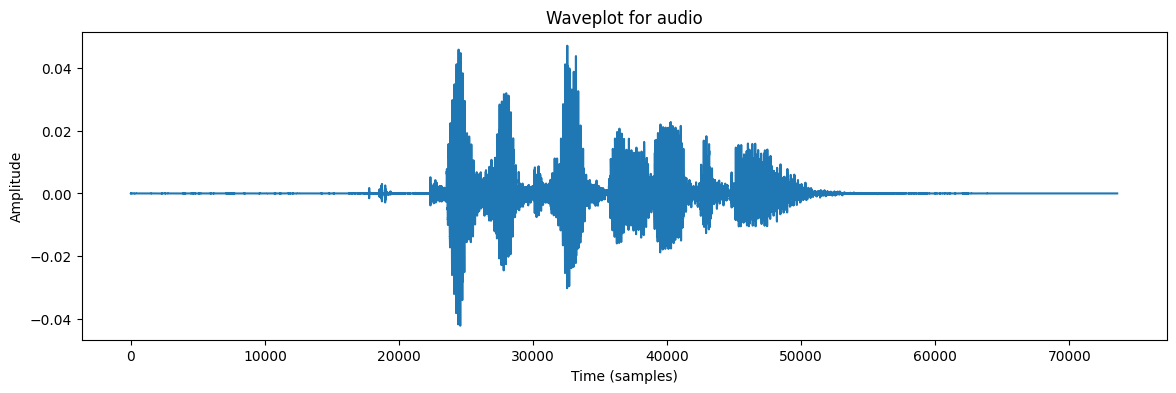

In [39]:
plt.figure(figsize=(14, 4))
# librosa.display.waveplot(y=data, sr=sample_rate)
# Khong su dung waveplot function
plt.plot(data)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveplot for audio")
plt.show()
Audio(path)

#### 2. Noise Injection


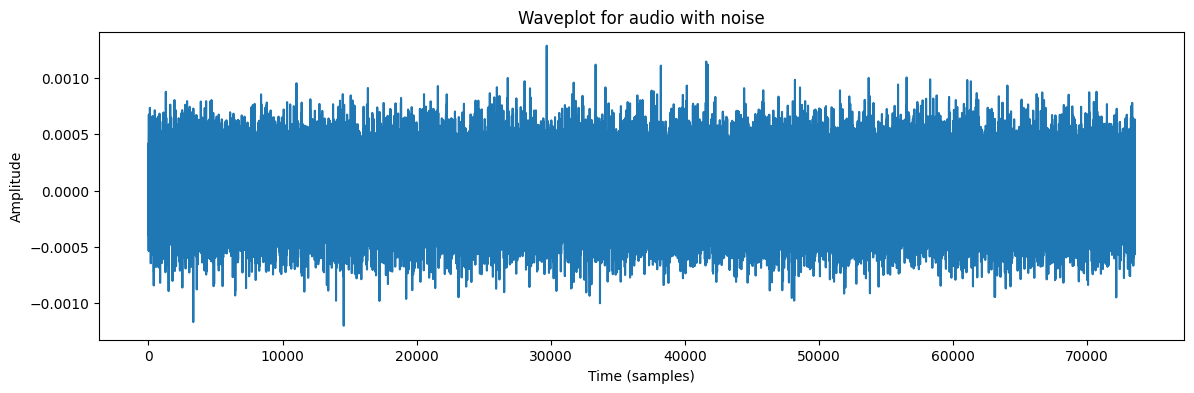

In [61]:
x = generate_env_noise(data)
plt.figure(figsize=(14, 4))
# librosa.display.waveplot(y=x, sr=sample_rate)
# Khong su dung waveplot function
plt.plot(x)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveplot for audio with noise")
plt.show()
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted


#### 3. Stretching


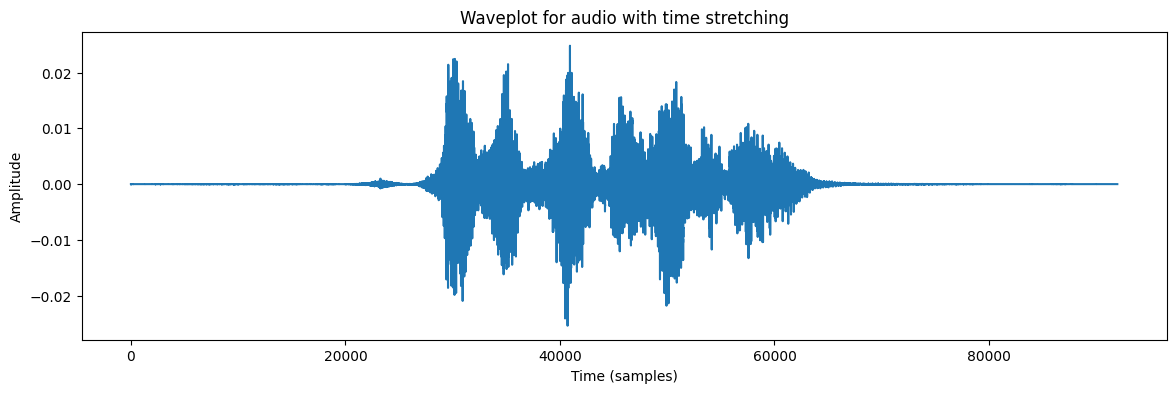

In [63]:
x = stretch(data)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveplot for audio with time stretching")
plt.show()
Audio(x, rate=sample_rate)

#### 4. Shifting


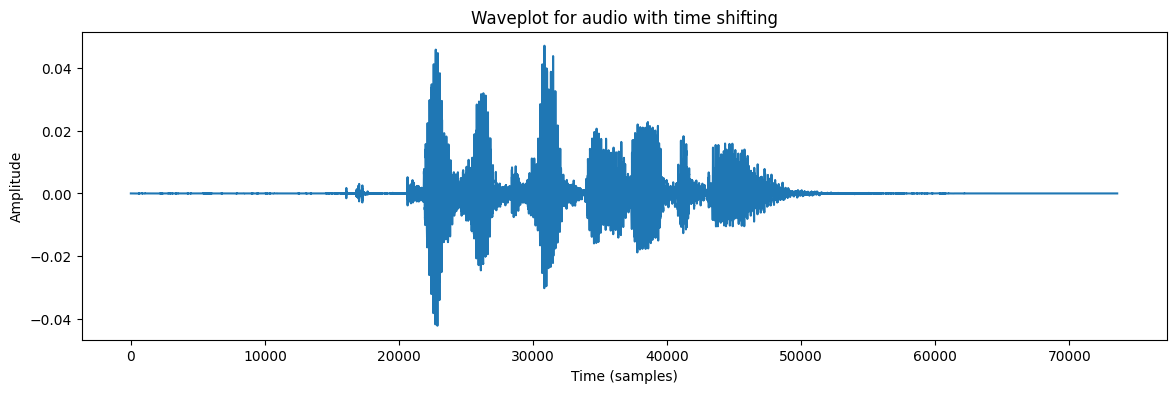

In [64]:
x = shift(data)
plt.figure(figsize=(14, 4))
# librosa.display.waveplot(y=x, sr=sample_rate)
# Khong su dung waveplot function
plt.plot(x)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveplot for audio with time shifting")
plt.show()
Audio(x, rate=sample_rate)

#### 5. Pitch


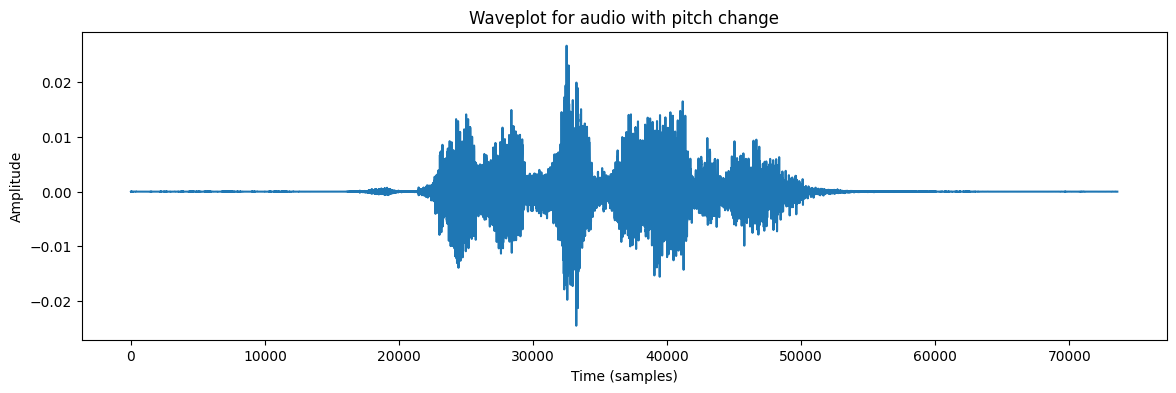

In [65]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveplot for audio with pitch change")
plt.show()
Audio(x, rate=sample_rate)

## Feature Extraction


In [69]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = generate_env_noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically

    return result

In [70]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [71]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [72]:
Features = pd.DataFrame(X)
Features["labels"] = Y
Features.to_csv("features.csv", index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.321275  0.729664  0.750033  0.730624  0.735275  0.713529  0.660531   
1  0.494480  0.914463  0.930125  0.946044  0.963691  0.918224  0.789381   
2  0.188256  0.622125  0.699215  0.753343  0.721212  0.701727  0.682356   
3  0.293566  0.673896  0.722096  0.723508  0.682302  0.680533  0.675352   
4  0.492843  0.888567  0.914617  0.935392  0.946207  0.964430  0.884398   

          7         8         9  ...           153           154  \
0  0.684966  0.733049  0.753972  ...  4.310903e-06  3.291511e-06   
1  0.791978  0.802918  0.824249  ...  1.318206e-05  1.171187e-05   
2  0.662828  0.686486  0.733960  ...  8.579052e-07  9.576654e-07   
3  0.628977  0.679179  0.707283  ...  6.984504e-06  7.034949e-06   
4  0.772534  0.776825  0.798675  ...  4.668663e-06  4.757549e-06   

            155           156           157           158       159       160  \
0  2.148075e-06  2.279739e-06  5.116493e-06  8.190282e-06  0.000007  0.000005   
1  1.206653e-05  1.267212e-05  1.281253e-05  1.251595e-05  0.000012  0.000012   
2  7.733596e-07  5.233101e-07  3.592860e-07  9.261693e-07  0.000002  0.000001   
3  6.654923e-06  6.979548e-06  1.214236e-05  9.640184e-06  0.000011  0.000006   
4  4.837466e-06  4.619221e-06  4.911258e-06  4.741962e-06  0.000005  0.000005   

            161   labels  
0  4.245834e-07  neutral  
1  1.260374e-05  neutral  
2  7.753986e-08  neutral  
3  4.254087e-07  neutral  
4  4.792445e-06  neutral  

[5 rows x 163 columns]

- We have applied data augmentation and extracted the features for each audio files and saved them.


## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.


In [73]:
X = Features.iloc[:, :-1].values
Y = Features["labels"].values

In [74]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

In [75]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [76]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [77]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

## Modelling


In [78]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential()
model.add(
    Conv1D(
        256,
        kernel_size=5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(x_train.shape[1], 1),
    )
)
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(128, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Flatten())
model.add(Dense(units=32, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
rlrp = ReduceLROnPlateau(
    monitor="loss", factor=0.4, verbose=0, patience=2, min_lr=0.0000001
)
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[rlrp],
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.1474 - loss: 2.0680 - val_accuracy: 0.2398 - val_loss: 1.9708 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.2100 - loss: 1.9926 - val_accuracy: 0.2481 - val_loss: 1.9180 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.2069 - loss: 1.9613 - val_accuracy: 0.2657 - val_loss: 1.9230 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.2147 - loss: 1.9289 - val_accuracy: 0.2722 - val_loss: 1.8147 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.2592 - loss: 1.8864 - val_accuracy: 0.3000 - val_loss: 1.7729 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.2672 - loss: 1.8249 - val_accuracy: 0.2778 - val_loss: 1.8429 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.2706 - loss: 1.8255 - val_

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5198 - loss: 1.5065
Accuracy of our model on test data :  53.33333611488342 %


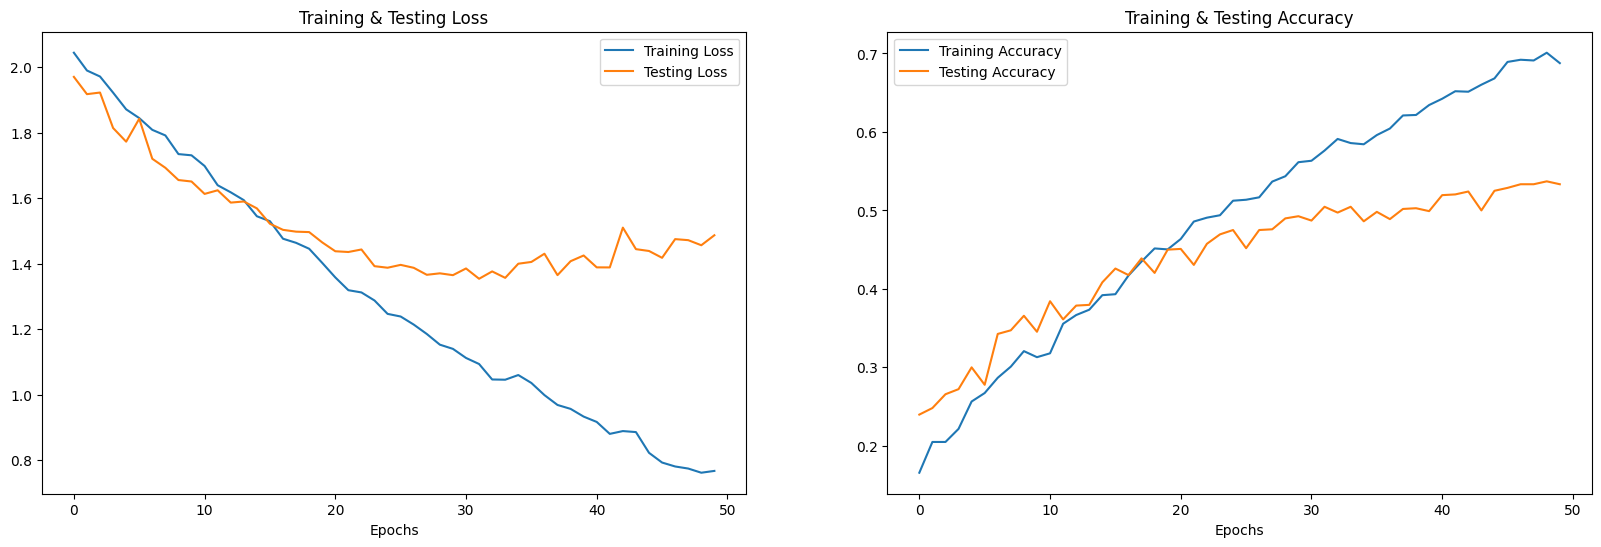

In [80]:
print(
    "Accuracy of our model on test data : ",
    model.evaluate(x_test, y_test)[1] * 100,
    "%",
)

epochs = [i for i in range(50)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
test_acc = history.history["val_accuracy"]
test_loss = history.history["val_loss"]

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label="Training Loss")
ax[0].plot(epochs, test_loss, label="Testing Loss")
ax[0].set_title("Training & Testing Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label="Training Accuracy")
ax[1].plot(epochs, test_acc, label="Testing Accuracy")
ax[1].set_title("Training & Testing Accuracy")
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [33]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [34]:
df = pd.DataFrame(columns=["Predicted Labels", "Actual Labels"])
df["Predicted Labels"] = y_pred.flatten()
df["Actual Labels"] = y_test.flatten()

df.head(1000)

Predicted Labels Actual Labels
0               fear          fear
1              angry         angry
2               fear          fear
3               calm          calm
4              angry         angry
..               ...           ...
995         surprise      surprise
996             calm          calm
997          disgust       disgust
998              sad           sad
999            angry         angry

[1000 rows x 2 columns]

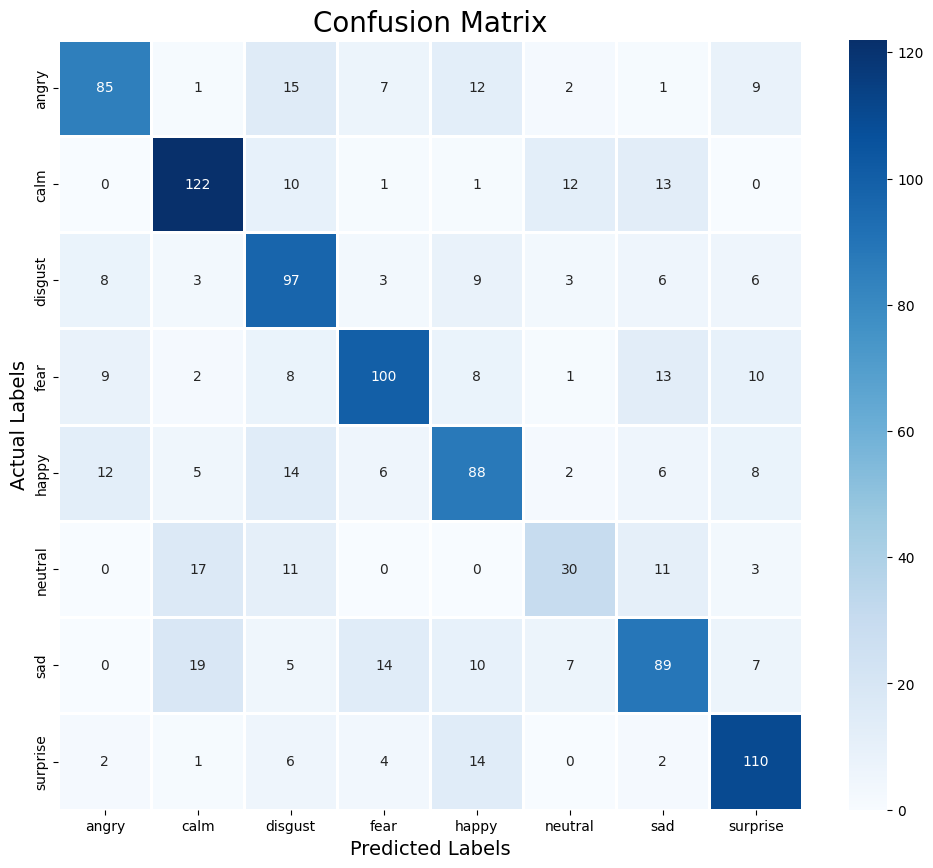

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(
    cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_]
)
sns.heatmap(cm, linecolor="white", cmap="Blues", linewidth=1, annot=True, fmt="")
plt.title("Confusion Matrix", size=20)
plt.xlabel("Predicted Labels", size=14)
plt.ylabel("Actual Labels", size=14)
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.73      0.64      0.69       132
        calm       0.72      0.77      0.74       159
     disgust       0.58      0.72      0.64       135
        fear       0.74      0.66      0.70       151
       happy       0.62      0.62      0.62       141
     neutral       0.53      0.42      0.47        72
         sad       0.63      0.59      0.61       151
    surprise       0.72      0.79      0.75       139

    accuracy                           0.67      1080
   macro avg       0.66      0.65      0.65      1080
weighted avg       0.67      0.67      0.67      1080

